In [1]:
from IPython.display import display
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB,ComplementNB,MultinomialNB
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score,roc_auc_score
import category_encoders as ce


In [2]:
traindata=pd.read_csv("Traindata.csv")
X = traindata.drop(['class'], axis=1)
y = traindata['class']

In [3]:
def encoding(X_train,X_test):
    encoder = ce.OrdinalEncoder(cols=['age', 'job', 'marital', 'education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome'])
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)
    return X_train,X_test

In [4]:
def printTree(clf,X_train):
    cls=['yes','no']
    dot_data = tree.export_graphviz(clf, out_file=None, 
                              feature_names=X_train.columns, 
                              class_names=cls,
                              filled=True, rounded=True,  
                              special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png('Decisiontree.png')



In [5]:
def printOutput(X_test_original,prediction,algoNum):
    X_test_original['Will subscribe a term deposit(yes/no)']=prediction
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)
    if(algoNum==1):
        X_test_original.to_csv("DecisionTreeOutput.csv",index=False)
    else:
        X_test_original.to_csv("NavieBayesOutput.csv",index=False)

In [6]:
def printHeatMap(cm,algoNum):
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    if(algoNum==1):
        result_path = 'DecisionTree_HeatMap.png'
    else:
        result_path='NavieBayes_HeatMap.png'
    plt.savefig(result_path, dpi=400)

In [7]:
def ModelEvalution(y_test,prediction,algoNum):
    cm=confusion_matrix(y_test,prediction)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    true_positive_rate = TP / float(TP + FN)
    false_positive_rate = FP / float(FP + TN)
    true_negative_rate=TN / float(TN + FP)
    false_negative_rate=FN / float(FN + TP)
    specificity = TN / (TN + FP)
    if(algoNum==1):
        printHeatMap(cm,1)
    else:
        printHeatMap(cm,2)
    return [round(classification_accuracy,3),round(classification_error,3),precision,recall,f1_score,true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate]


In [8]:
def crossValidation_Score(clf,X_train,y_train):
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
    cross_validation_score=scores.mean()
    return round(scores.mean(),3)


In [9]:
def ROC_Curve(clf,X_test,y_test,algoNum):
    y_pred1 = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label = 'yes')
    ROC_AUC = roc_auc_score(y_test, y_pred1)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Decision Classifier for Predicting Subscription')
    plt.xlabel('False Positive Rate (Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    if(algoNum==1):
        result_path = 'DecisionTree_ROCcurve.png'
    else:
        result_path='NavieBayes_ROCcurve.png'
    plt.savefig(result_path, dpi=400)
    return ROC_AUC

    

In [10]:
def Decisiontree():
    X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=10)
    X_test_original=X_test.copy(deep=False)
    X_train_original=X_train.copy(deep=False)
    X_train,X_test=encoding(X_train,X_test)
    clf = DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=3,random_state=0) #max_depth is maximum number of levels in the tree
    clf.fit(X_train,y_train)
    printTree(clf,X_train)
    prediction=clf.predict(X_test)
    printOutput(X_test_original,prediction,1)
    evalList=ModelEvalution(y_test,prediction,1)
    evalList.append(crossValidation_Score(clf,X_train,y_train))
    evalList.append(ROC_Curve(clf,X_test,y_test,1))
    return evalList

C:\Users\Krupal\anaconda3\envs\dtree\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


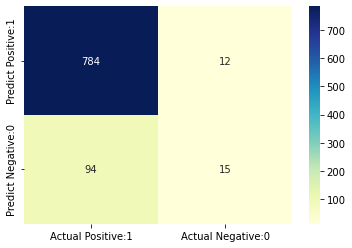

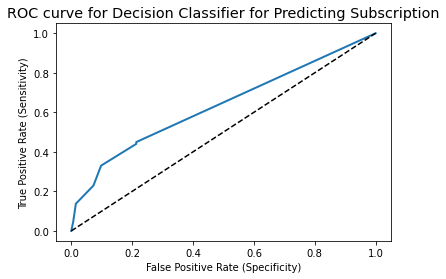

In [11]:
dtlist=Decisiontree()

In [12]:
def NaiveBayes():
    X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=10)
    X_test_original=X_test.copy(deep=False)
    X_train_original=X_train.copy(deep=False)
    X_train,X_test=encoding(X_train,X_test)
    nv = GaussianNB()
    nv.fit(X_train, y_train)
    y_pred = nv.predict(X_test)
    printOutput(X_test_original,y_pred,2)
    evalList=ModelEvalution(y_test,y_pred,2)
    evalList.append(crossValidation_Score(nv,X_train,y_train))
    evalList.append(ROC_Curve(nv,X_test,y_test,2))
    return evalList

C:\Users\Krupal\anaconda3\envs\dtree\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


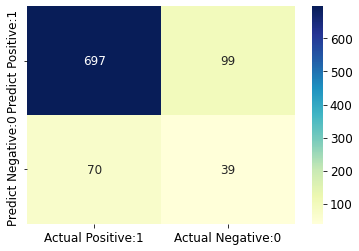

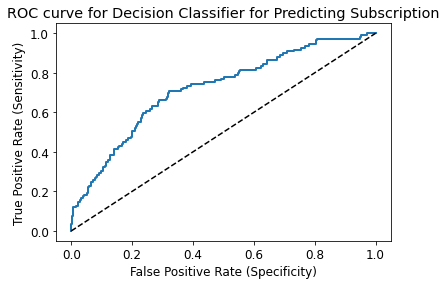

In [13]:
nbList=NaiveBayes()

In [14]:

data = {'Decision Tree Algorithm':dtlist,'Navie Bayes Algorithm':nbList}
headers=["Classification Accuracy Score","Classification Error", "Precision", "Recall", "F1 Score","True Positive Rate","False Positive Rate","True Negative Rate","False Negative Rate","Cross Validation Score","ROC_AUC"] 
print(pd.DataFrame(data, headers))

                               Decision Tree Algorithm  Navie Bayes Algorithm
Classification Accuracy Score           0.883                   0.813        
Classification Error                    0.117                   0.187        
Precision                               0.985                   0.876        
Recall                                  0.893                   0.909        
F1 Score                                0.937                   0.892        
True Positive Rate                      0.893                   0.909        
False Positive Rate                     0.444                   0.717        
True Negative Rate                      0.556                   0.283        
False Negative Rate                     0.107                   0.091        
Cross Validation Score                  0.893                   0.823        
ROC_AUC                                 0.633                   0.719        
